# 1. Data Preprocessing:

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [51]:
# Load MNIST dataset
(X_train, y_train), (_, _) = mnist.load_data()
print(f"Original X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


Original X_train shape: (60000, 28, 28), y_train shape: (60000,)


In [68]:
# Normalize pixel values to [0, 1]
X_train = X_train.astype("float32") / 255.0
# print(f"X_train after normalization: {X_train[0]}")

In [53]:
# Flatten the 28x28 images into 1D vectors
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
print(f"X_train shape after flattening: {X_train_flattened.shape}")

X_train shape after flattening: (60000, 784)


In [54]:
#  Dimensionality reduction with PCA
pca = PCA(n_components=50)  # Retain 50 components for better performance
X_train_pca = pca.fit_transform(X_train_flattened)

print(f"Original shape before PCA: {X_train_flattened.shape}")
print(f"Shape after PCA: {X_train_pca.shape}")
print(f"Explained variance ratio (percentage of variance explained by each component): {pca.explained_variance_ratio_}")

Original shape before PCA: (60000, 784)
Shape after PCA: (60000, 50)
Explained variance ratio (percentage of variance explained by each component): [0.09704665 0.07095922 0.06169096 0.05389416 0.04868804 0.04312227
 0.03271929 0.02883891 0.02762031 0.02357002 0.02109189 0.0202299
 0.01715819 0.01692109 0.01578641 0.01482952 0.01324562 0.01276897
 0.01187262 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786367 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586581 0.00570019 0.0054361
 0.00505779 0.00487847 0.00481415 0.00472243 0.00456733 0.00444831
 0.00418451 0.00398104 0.00384927 0.00374597 0.00361914 0.00350725
 0.00339369 0.00321353]


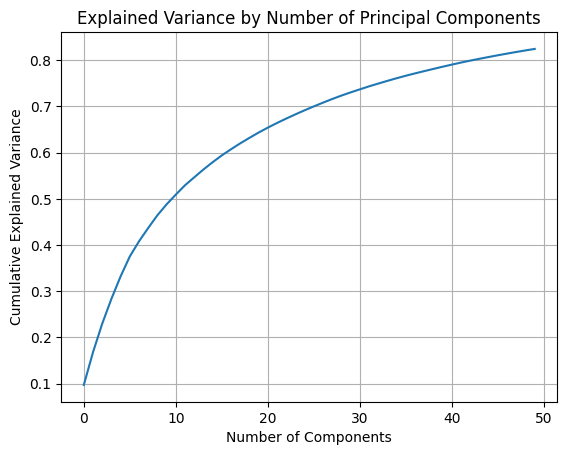

In [55]:
# Optional: Visualize the explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# 2. Clustering with K-means:

In [58]:
def kmeans(X, K, max_iters=100, tol=1e-4):
    #Setting a random seed ensures reproducibility.
    np.random.seed(42)
    # Randomly initialize centroids
    #Randomly select K data points from X as the initial centroids.
    centroids = X[np.random.choice(X.shape[0], K, replace=False)]
    # print(f"Initial centroids: {centroids[:5]}")  # Print first 5 centroids for inspection
    
    for i in range(max_iters):
        # Step 1: Assign clusters
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        # print(f"Iteration {i+1}: Cluster assignments (first 10): {cluster_assignments[:10]}")

        # Step 2: Update centroids
        new_centroids = np.array([X[cluster_assignments == k].mean(axis=0) for k in range(K)])
        # print(f"Iteration {i+1}: New centroids (first 5): {new_centroids[:5]}")

        # Step 3: Convergence check
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        # print(f"Iteration {i+1}: Centroid shift: {centroid_shift}")

        if centroid_shift < tol:
            # print(f"Convergence reached at iteration {i+1}")
            break
        
        centroids = new_centroids

    return centroids, cluster_assignments



In [59]:
# Apply K-means on PCA-transformed data
K = 10
centroids, cluster_assignments = kmeans(X_train_pca, K)



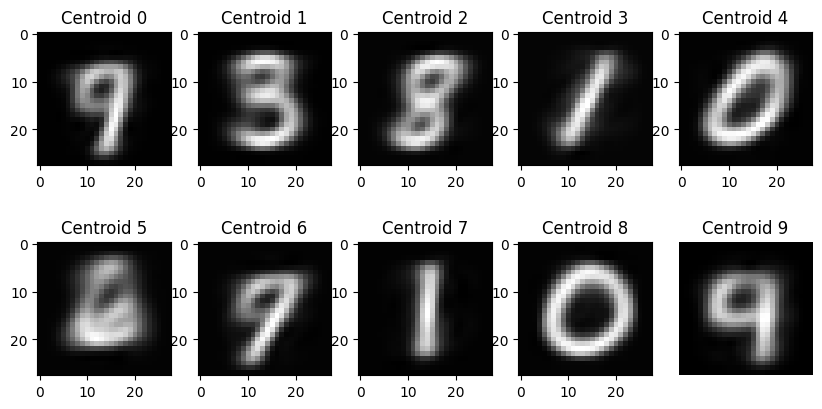

In [60]:
# Visualize centroids
plt.figure(figsize=(10, 5))
for i, centroid in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca.inverse_transform(centroid).reshape(28, 28), cmap='gray')
    plt.title(f"Centroid {i}")
plt.axis('off')
plt.show()

# 3. Clustering with KSOM:

In [61]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from collections import Counter

In [62]:
class KSOM:
    def __init__(self, grid_shape, input_dim, learning_rate=0.5, sigma=1.0):
        self.grid_shape = grid_shape
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = np.random.rand(np.prod(grid_shape), input_dim)  # Random initialization
        self.grid = np.array([np.unravel_index(i, grid_shape) for i in range(np.prod(grid_shape))])
    
    def train(self, X, epochs=100):
        for epoch in range(epochs):
            for x in X:
                # Calculate distances to find BMU
                distances = np.linalg.norm(self.weights - x, axis=1)
                bmu_index = np.argmin(distances)
                
                # Update weights for the BMU and its neighbors
                for i, weight in enumerate(self.weights):
                    grid_distance = np.linalg.norm(self.grid[bmu_index] - self.grid[i])
                    if grid_distance <= self.sigma:
                        influence = np.exp(-grid_distance**2 / (2 * self.sigma**2))
                        self.weights[i] += self.learning_rate * influence * (x - weight)
            
            # Decay learning rate and sigma
            self.learning_rate *= 0.9
            self.sigma *= 0.9
    
    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.weights - x, axis=1)
            predictions.append(np.argmin(distances))
        return np.array(predictions)

In [63]:
# Load MNIST dataset
from tensorflow.keras.datasets import mnist
(X_train, y_train), (_, _) = mnist.load_data()

# Normalize and flatten images
X_train = X_train.astype("float32") / 255.0
X_train_flattened = X_train.reshape(X_train.shape[0], -1)

# Subset for faster training
subset_size = 10000
indices = np.random.choice(X_train_flattened.shape[0], subset_size, replace=False)
X_train_subset = X_train_flattened[indices]
y_train_subset = y_train[indices]

In [64]:
# Train KSOM
ksom = KSOM(grid_shape=(5, 5), input_dim=X_train_flattened.shape[1], learning_rate=0.5, sigma=2.0)
ksom.train(X_train_subset, epochs=20)

# Predict clusters for each data point
cluster_assignments = ksom.predict(X_train_subset)

# Assign labels to neurons based on majority voting
neuron_labels = {}
for neuron_id in range(np.prod(ksom.grid_shape)):
    # Get data points assigned to this neuron

    
    points_in_neuron = y_train_subset[cluster_assignments == neuron_id]
    if len(points_in_neuron) > 0:
        # Assign the most common label
        neuron_labels[neuron_id] = Counter(points_in_neuron).most_common(1)[0][0]
    else:
        neuron_labels[neuron_id] = -1  # No data assigned to this neuron
    if neuron_id % 10 == 0:  # Print every 10th neuron for inspection
        print(f"Neuron {neuron_id}: Most common label is {neuron_labels[neuron_id]}")

Neuron 0: Most common label is 0
Neuron 10: Most common label is 4
Neuron 20: Most common label is 7


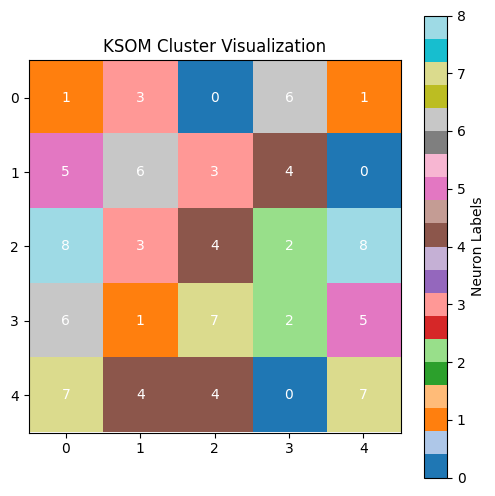

In [34]:
# Visualize clusters on the KSOM grid
grid_labels = np.array([neuron_labels.get(i, -1) for i in range(np.prod(ksom.grid_shape))]).reshape(ksom.grid_shape)

plt.figure(figsize=(6, 6))
plt.imshow(grid_labels, cmap='tab20', interpolation='nearest')
for i in range(ksom.grid_shape[0]):
    for j in range(ksom.grid_shape[1]):
        label = grid_labels[i, j]
        plt.text(j, i, f"{label}" if label != -1 else "", ha='center', va='center', color='white')
plt.colorbar(label="Neuron Labels")
plt.title("KSOM Cluster Visualization")
plt.show()

# 4. Performance Comparison:

In [38]:
import psutil
import os
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Function to calculate memory usage
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 2)  # Memory in MB

In [40]:
# Function to calculate purity
def calculate_purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [41]:
# Evaluate K-means
start_time = time()
centroids, kmeans_clusters = kmeans(X_train_subset, K=10)  # Using your kmeans function
kmeans_time = time() - start_time
kmeans_memory = get_memory_usage()

In [42]:
# Compute clustering quality metrics for K-means
kmeans_silhouette = silhouette_score(X_train_subset, kmeans_clusters)
kmeans_ari = adjusted_rand_score(y_train_subset, kmeans_clusters)
kmeans_purity = calculate_purity(y_train_subset, kmeans_clusters)

In [43]:
# Evaluate KSOM
start_time = time()
ksom_clusters = ksom.predict(X_train_subset)  # Assuming KSOM is trained and defined earlier
ksom_time = time() - start_time
ksom_memory = get_memory_usage()

In [44]:
# Compute clustering quality metrics for KSOM
ksom_silhouette = silhouette_score(X_train_subset, ksom_clusters)
ksom_ari = adjusted_rand_score(y_train_subset, ksom_clusters)
ksom_purity = calculate_purity(y_train_subset, ksom_clusters)

In [45]:
# Step 4: Displaying Comparison Table
print("Step 4: Comparing K-means and KSOM metrics:")
print(f"{'Metric':<25}{'K-means':<15}{'KSOM':<15}")
print(f"{'-' * 55}")
print(f"{'Execution Time (s)':<25}{kmeans_time:<15.4f}{ksom_time:<15.4f}")
print(f"{'Memory Usage (MB)':<25}{kmeans_memory:<15.2f}{ksom_memory:<15.2f}")
print(f"{'Silhouette Score':<25}{kmeans_silhouette:<15.4f}{ksom_silhouette:<15.4f}")
print(f"{'Adjusted Rand Index':<25}{kmeans_ari:<15.4f}{ksom_ari:<15.4f}")
print(f"{'Purity':<25}{kmeans_purity:<15.4f}{ksom_purity:<15.4f}\n")

Step 4: Comparing K-means and KSOM metrics:
Metric                   K-means        KSOM           
-------------------------------------------------------
Execution Time (s)       27.9800        1.1168         
Memory Usage (MB)        68.48          88.35          
Silhouette Score         0.0708         0.0600         
Adjusted Rand Index      0.3775         0.3157         
Purity                   0.5940         0.7369         



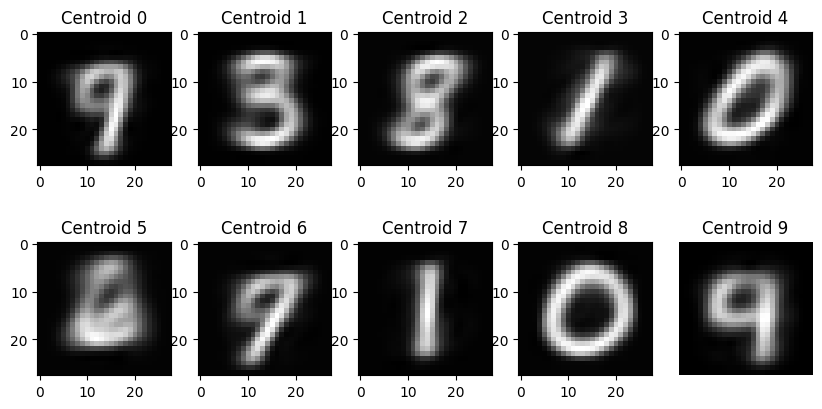

In [66]:
# Visualize centroids
plt.figure(figsize=(10, 5))
for i, centroid in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pca.inverse_transform(centroid).reshape(28, 28), cmap='gray')
    plt.title(f"Centroid {i}")
plt.axis('off')
plt.show()

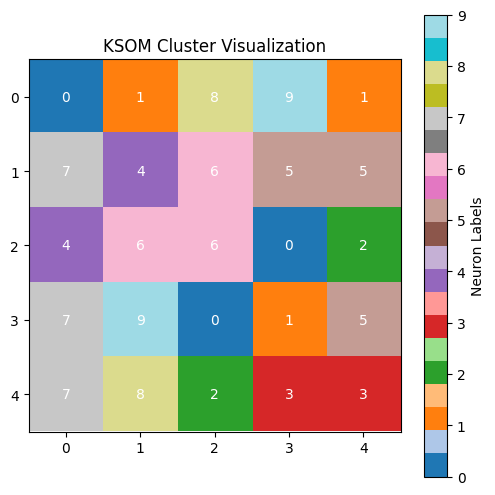

In [67]:
# Visualize clusters on the KSOM grid
grid_labels = np.array([neuron_labels.get(i, -1) for i in range(np.prod(ksom.grid_shape))]).reshape(ksom.grid_shape)

plt.figure(figsize=(6, 6))
plt.imshow(grid_labels, cmap='tab20', interpolation='nearest')
for i in range(ksom.grid_shape[0]):
    for j in range(ksom.grid_shape[1]):
        label = grid_labels[i, j]
        plt.text(j, i, f"{label}" if label != -1 else "", ha='center', va='center', color='white')
plt.colorbar(label="Neuron Labels")
plt.title("KSOM Cluster Visualization")
plt.show()